Hi, Welcome to the Notebook! The following notebook is the implementaion of the Kmeans algorithm on a country dataset.
Objective: To categorise(cluster) countries using socio-economic and health factors that determine the overall development of the country.
Example Problem Statement: CEO of an NGO has to make decision to choose the countries that are in the direst need of aid. Hence, 
My job as a Data analyst is to categorise the countries using some socio-economic and health factors that determine the
overall development of the country. 
Then I need to suggest the countries which the CEO needs to focus on the most.    

This Notebook looks at how different ways of initial center selection affects the kmeans algorithm and also at the objective function(phi).

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [105]:
def load_data(file_path="C:\\Users\\harsh\\OneDrive\\Desktop\\Summer Project-KMeans\\Country_data.csv"):
    data=pd.read_csv(file_path)
    return data

def standardize_data(data):
    features=data.drop(columns=['country'])
    scaler=StandardScaler()
    scaled_features=scaler.fit_transform(features)
    scaled_data=pd.DataFrame(scaled_features,columns=features.columns)
    return scaled_data

def plot_distributions(scaled_data):
    plt.figure(figsize=(15,10))
    for i,column in enumerate(scaled_data.columns,1):
        plt.subplot(3,4,i)
        sns.histplot(scaled_data[column],kde=True)
        plt.title(f'{column}Distribution')
    plt.tight_layout()
    plt.show()



In [116]:
# K-means++ initialization
def kmeans_pp_init(data, k, seed=30):
    """
    Perform K-means++ initialization.
    Args:
    - data: NumPy array of shape (n_samples, n_features)
    - k: Number of clusters
    - seed: Random seed for reproducibility
    Returns:
    - initial_centers: NumPy array of shape (k, n_features)
    """
    np.random.seed(seed)
    n_samples = data.shape[0]
    
    # Step 1: Randomly select the first center
    centers = [data[np.random.choice(n_samples)]]
    
    # Step 2: Iteratively select the remaining k-1 centers
    for _ in range(1, k):
        # Compute distances to the nearest selected center
        distances = np.min(cdist(data, np.array(centers)), axis=1)
        
        # Compute probabilities proportional to squared distances
        probabilities = distances**2 / np.sum(distances**2)
        
        # Select the next center based on probabilities
        next_center = data[np.random.choice(n_samples, p=probabilities)]
        centers.append(next_center)
    
    return np.array(centers)

In [117]:
# K-means clustering
def kmeans_clustering(data, k, init_centers, max_iters=100, tol=1e-4):
    """
    Perform K-means clustering.
    Args:
    - data: NumPy array of shape (n_samples, n_features)
    - k: Number of clusters
    - init_centers: Initial cluster centers
    - max_iters: Maximum number of iterations
    - tol: Tolerance for convergence
    Returns:
    - labels: Cluster labels for each data point
    - final_centers: Final cluster centers
    """
    centers = init_centers
    for _ in range(max_iters):
        # Step 1: Assign each point to the nearest center
        distances = cdist(data, centers)
        labels = np.argmin(distances, axis=1)
        
        # Step 2: Update cluster centers as the mean of assigned points
        new_centers = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        
        # Convergence check
        if np.linalg.norm(new_centers - centers) < tol:
            break
        centers = new_centers
    
    return labels, centers

In [118]:
# Visualization function
def visualise_clusters_with_centers(data, labels, initial_centers, final_centers):
    """
    Visualize clusters, initial centers, and final centers in 2D using PCA.
    Args:
    - data: NumPy array of shape (n_samples, n_features)
    - labels: Cluster labels for each data point
    - initial_centers: Initial cluster centers
    - final_centers: Final cluster centers
    """
    # Reduce data and centers to 2D using PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    reduced_initial_centers = pca.transform(initial_centers)
    reduced_final_centers = pca.transform(final_centers)
    
    # Plot data points colored by cluster labels
    plt.figure(figsize=(10, 8))
    for cluster in np.unique(labels):
        cluster_points = reduced_data[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.6)
    
    # Plot initial centers in one color
    plt.scatter(reduced_initial_centers[:, 0], reduced_initial_centers[:, 1], 
                c='red', marker='X', s=200, label='Initial Centers')
    
    # Plot final centers in another color
    plt.scatter(reduced_final_centers[:, 0], reduced_final_centers[:, 1], 
                c='blue', marker='X', s=200, label='Final Centers')
    
    plt.title('K-means Clustering with Initial and Final Centers')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid()
    plt.show()

In [125]:
# Visualize the potential function
def plot_potential_function(phi_values):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(phi_values) + 1), phi_values, marker='o', color='b', label='Potential Function')
    plt.title('Potential Function Over Iterations(\u03C6)')
    plt.xlabel('Iteration')
    plt.ylabel('Potential Function Value')
    plt.grid()
    plt.legend()
    plt.show()

In [126]:
# Track potential function
#The objective function (potential function) plotted against the number of iterations reveals how quickly 
#the algorithm converges.
def track_potential_function(data, k, max_iters=100, seed=42):
    np.random.seed(seed)
    n_samples = data.shape[0]
    centers = data[np.random.choice(n_samples, k, replace=False)]  # Random initialization
    phi_values = []

    for _ in range(max_iters):
        # Step 1: Assign each point to the nearest center
        distances = cdist(data, centers, metric='sqeuclidean')
        labels = np.argmin(distances, axis=1)

        # Step 2: Compute potential function
        min_distances = np.min(distances, axis=1)
        phi = np.sum(min_distances)
        phi_values.append(phi)

        # Step 3: Update centers as the mean of assigned points
        new_centers = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        if np.allclose(centers, new_centers):
            break
        centers = new_centers

    return phi_values


In [127]:
country_data=load_data()
scaled_data = standardize_data(country_data)
scaled_data_array=scaled_data.to_numpy() #convert to numpy aaray for calculations

Initial centers after kmeans++:  [[ 1.93319565e+00 -3.28434272e-04  3.99587725e-01  1.12266870e-01
  -8.60325858e-01  1.23523658e+00 -1.47247282e+00  2.37992200e+00
  -6.91164015e-01]
 [-5.19052362e-01  3.43618277e-01 -2.21167159e-01  3.48418872e-01
  -3.50915535e-01 -3.75920817e-01  7.15536832e-01 -5.35320778e-01
  -4.82887070e-01]
 [-8.47345199e-01 -5.23566517e-01  1.85653595e+00 -7.78481908e-01
   1.02783776e+00 -6.38753914e-01  1.22306484e+00 -6.08201847e-01
   1.51232507e+00]
 [-8.82164136e-01  4.89908270e+00  3.48466735e-01  3.94041511e+00
   3.87899553e+00 -3.94897936e-01  1.21178644e+00 -8.73223918e-01
   5.03650669e+00]]
Final centers after the Kmeans iteration:  [[ 1.38209405 -0.44902617 -0.17115749 -0.1972886  -0.69747801  0.40850458
  -1.27706228  1.39559546 -0.60950969]
 [-0.41103452  0.0076087  -0.20315863  0.04911688 -0.21707832 -0.03332883
   0.24812404 -0.43375408 -0.33115921]
 [-0.82860929  0.17262066  0.85918977 -0.29637276  1.46227512 -0.47818851
   1.10764922 -0.76

C:\Users\harsh\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
C:\Users\harsh\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


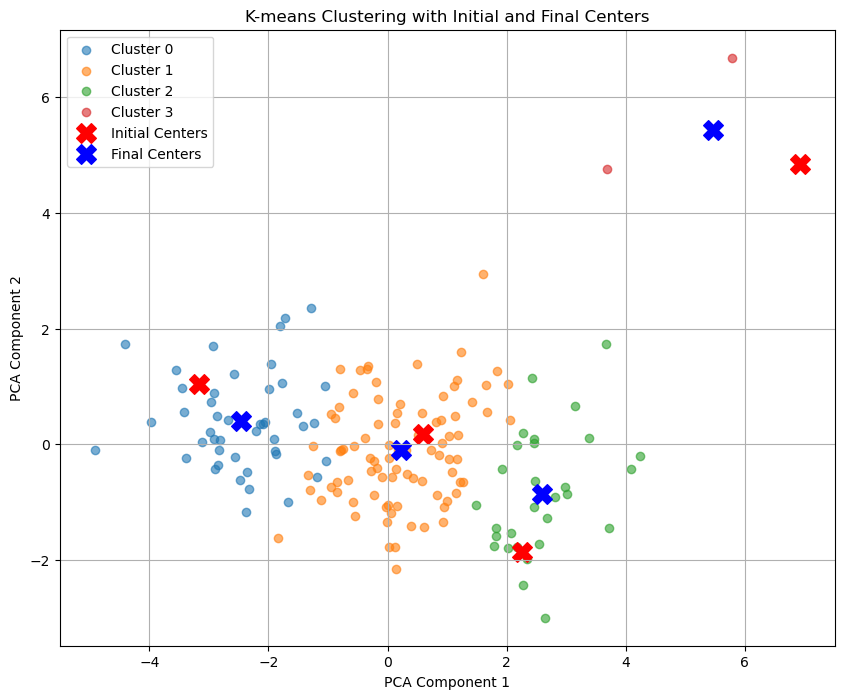

In [128]:
# Number of clusters
k = 4

# Step 1: Initialize centers using K-means++
initial_centers = kmeans_pp_init(scaled_data_array, k)
print("Initial centers after kmeans++: ", initial_centers)
# Step 2: Perform K-means clustering
labels, final_centers = kmeans_clustering(scaled_data_array, k, initial_centers)
print("Final centers after the Kmeans iteration: ",final_centers)
# Step 3: Visualize clusters with initial and final centers
visualise_clusters_with_centers(scaled_data, labels, initial_centers, final_centers)

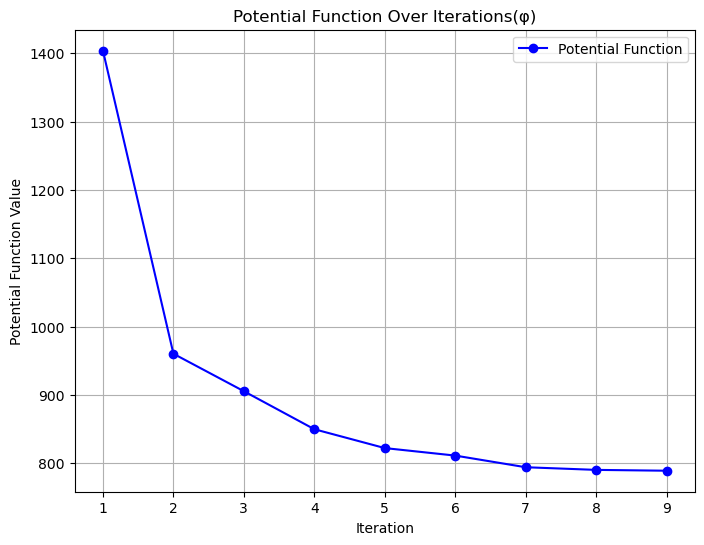

In [129]:
#STEP 4-Track potential function
phi_values = track_potential_function(scaled_data_array, k)
plot_potential_function(phi_values) 

Initial centers after K-means++:
 [[0.24185229 0.09310277]
 [0.21582103 0.62289048]
 [0.63230583 0.63352971]
 [0.89721576 0.90041806]]
Final centers after the K-means iteration:
 [[0.28899172 0.16395503]
 [0.21629438 0.73453688]
 [0.78320692 0.30285525]
 [0.71123026 0.76365139]]


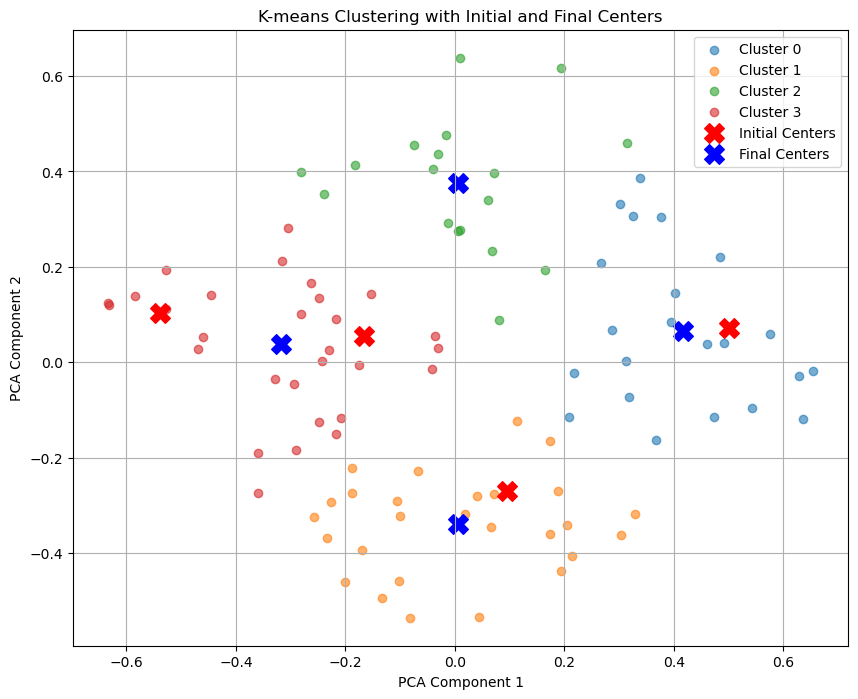

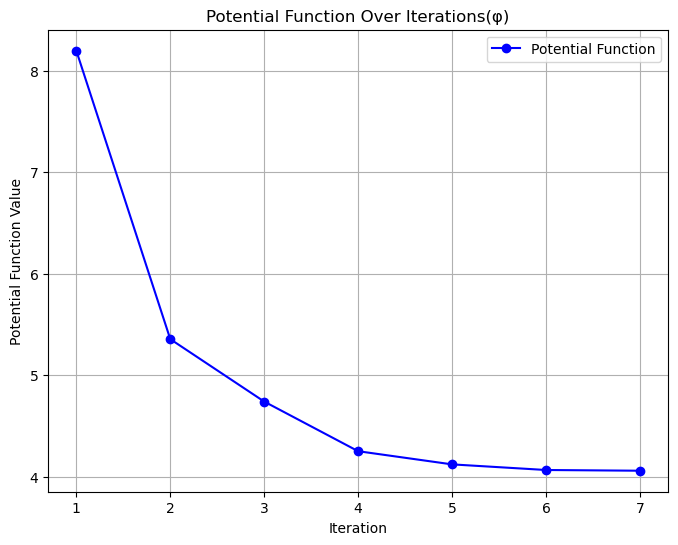

In [134]:
#Visualising with simpler data

data= np.random.rand(100, 2)  # 100 points with 2 features
k = 4  # Number of clusters

# Step 1: Initialize centers using K-means++ 
initial_centers = kmeans_pp_init(data, k)
print("Initial centers after K-means++:\n", initial_centers)

# Step 2: Perform K-means clustering 
labels, final_centers = kmeans_clustering(data, k, initial_centers)
print("Final centers after the K-means iteration:\n", final_centers)

# Step 3: Visualize clusters with initial and final centers 
visualise_clusters_with_centers(data, labels, initial_centers, final_centers)


#STEP 4-Track potential function
phi_values = track_potential_function(data, k)
plot_potential_function(phi_values) 

Experimenting with manually choosing random centres and observing initial and final clusters after applying kmeans algorithm.

In [151]:
# Step 1: Manually specify initial centers
#Dynamically generate random manual centers that match the dataset’s dimensionality
n_features = scaled_data_array.shape[1]
k=4
manual_centers = np.random.uniform(
        low=-3, high=5, size=(k, n_features)  # Random centers in the feature space range
)
print(manual_centers)

[[-1.08350487 -1.84084102  0.91562208  4.88520363 -1.06355783  2.37708438
   3.09295692 -1.09889965  2.82573079]
 [-0.05773494  2.05844664  2.06823769  1.28619747 -2.27768184  3.68241996
  -0.43375948 -1.50785192 -2.67379887]
 [ 1.72714355  2.42051489 -2.86729737  1.09674447 -1.1880338   2.16138232
  -1.60506857  2.5275019   0.09388277]
 [ 4.49383991 -1.89983245 -0.27146919 -2.09221183  4.39754895  4.01871483
  -0.93646698  2.27987237  3.5377776 ]]


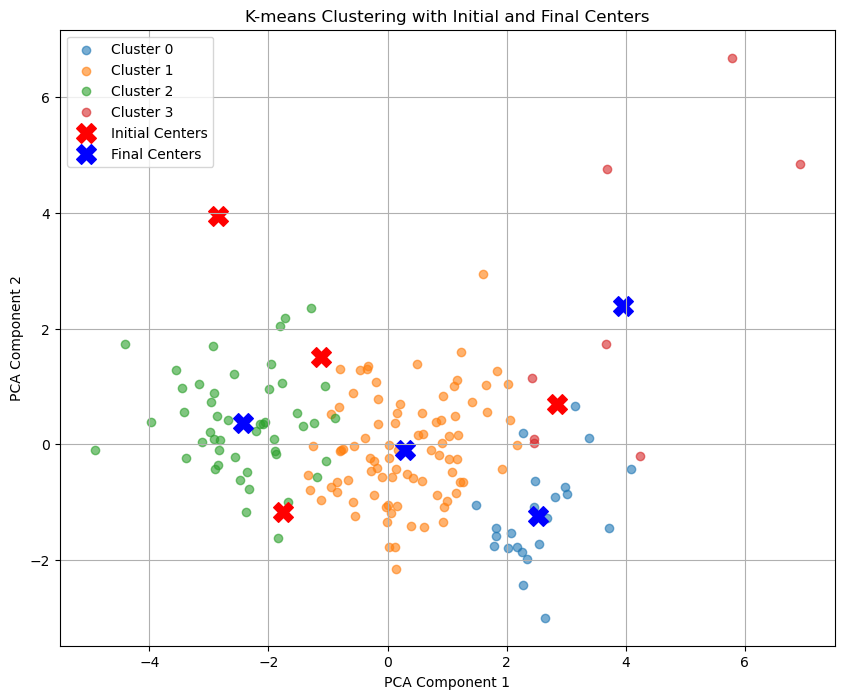

In [152]:
 # Step 2: Perform K-means clustering
labels, final_centers = kmeans_clustering(scaled_data_array, k, manual_centers)

# Step 3: Visualize clusters with initial and final centers
visualise_clusters_with_centers(scaled_data_array, labels, manual_centers, final_centers)

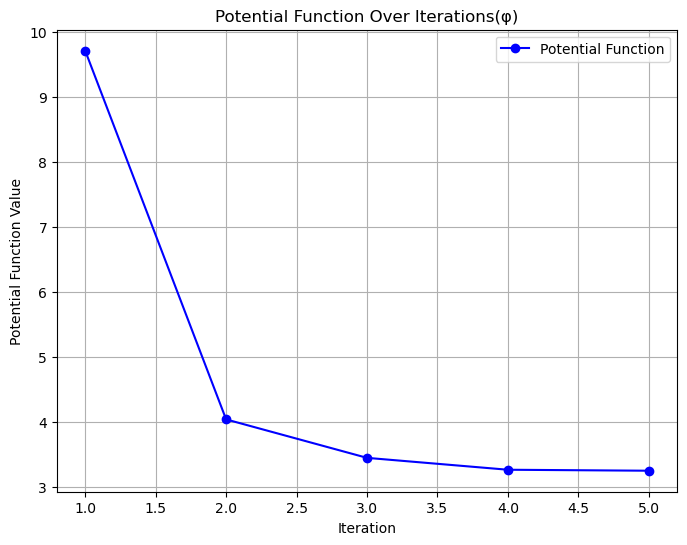

In [146]:
#STEP 4-Track potential function
phi_values = track_potential_function(data, k)
plot_potential_function(phi_values) 


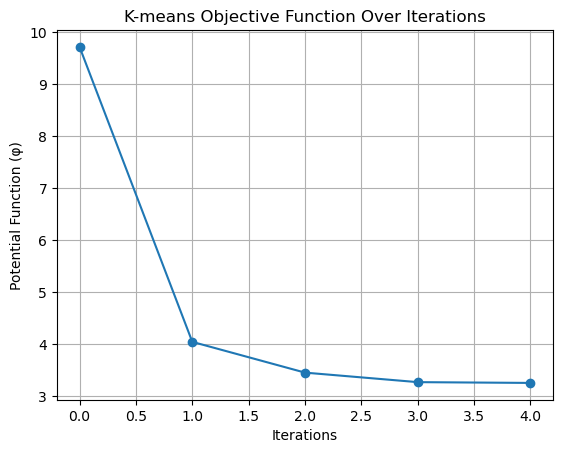

In [135]:
# Example Usage with simpler data
data = np.random.rand(100, 2)  # Dummy data with 100 points and 2 features
k = 5  # Number of clusters
phi_values = track_potential_function(data, k)

# Plot the objective function over iterations
plt.plot(phi_values, marker='o')
plt.title('K-means Objective Function Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Potential Function (\u03C6)')
plt.grid()
plt.show()

Plot the center displacement (distance between old and new cluster centers) at each iteration.
The displacement decreases as K-means converges. This can help visualize the stability of centers over iterations.

In [147]:
def track_center_displacement(data, k, max_iters=100, tol=1e-4):
    np.random.seed(42)
    n_samples = data.shape[0]
    centers = data[np.random.choice(n_samples, k, replace=False)]  # Random initialization
    center_displacements = []

    for _ in range(max_iters):
        # Step 1: Assign each point to the nearest center
        distances = cdist(data, centers, metric='sqeuclidean')
        labels = np.argmin(distances, axis=1)

        # Step 2: Update centers as the mean of assigned points
        new_centers = np.array([data[labels == i].mean(axis=0) for i in range(k)])

        # Compute displacement of centers
        displacement = np.linalg.norm(new_centers - centers, axis=1).sum()
        center_displacements.append(displacement)

        if displacement < tol:  # Convergence check
            break
        centers = new_centers

    return center_displacements

def plot_center_displacement(displacements):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(displacements) + 1), displacements, marker='o', color='r', label='Center Displacement')
    plt.title('Cluster Center Displacement Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Total Displacement')
    plt.grid()
    plt.legend()
    plt.show()

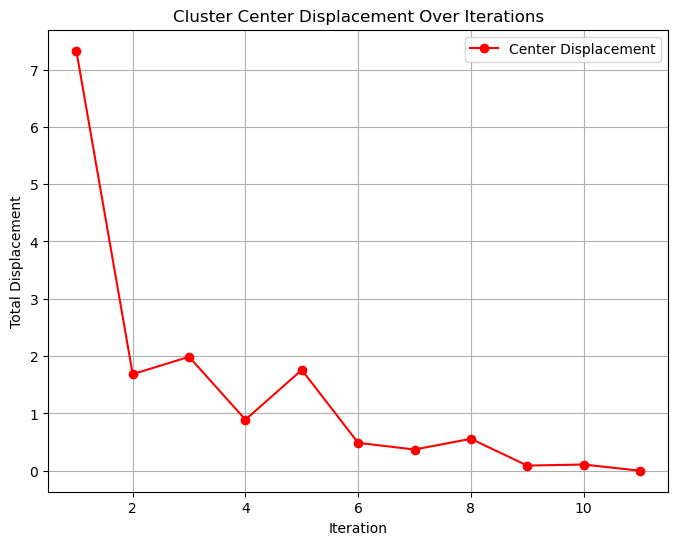

In [148]:
displacements = track_center_displacement(scaled_data_array, k)
plot_center_displacement(displacements)